In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
)

In [3]:
df = pd.read_csv("../data/processed/oversampled_heart_disease_dataset.csv")

In [4]:
df.shape

(6300, 16)

In [5]:
target_col = 'TenYearCHD'

X = df.drop(columns=[target_col])
y = df[target_col]

In [6]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Recursive Elimination

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score
import time

def recursive_feature_elimination(model, X_train, X_test, y_train, y_test, scoring='roc_auc', early_stop_drop=0.01):
    """
    Perform manual recursive feature elimination using feature importances.
    """
    current_features = list(X_train.columns)
    feature_sets = []
    scores_list = []
    n_features_list = []
    best_score = 0
    prev_score = 0
    start_time = time.time()  # Start the timer
    
    print("\n=== Feature Elimination ===\n")
    
    while len(current_features) > 1:
        # train model
        model.fit(X_train[current_features], y_train)
        
        # predict
        y_pred = model.predict(X_test[current_features])
        if scoring == 'roc_auc':
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test[current_features])[:, 1]
                score = roc_auc_score(y_test, y_prob)
            else:
                y_prob = model.decision_function(X_test[current_features])
                score = roc_auc_score(y_test, y_prob)
        elif scoring == 'accuracy':
            score = accuracy_score(y_test, y_pred)
        else:
            raise ValueError("Scoring must be 'roc_auc' or 'accuracy'")
        
        # save results
        scores_list.append(score)
        n_features_list.append(len(current_features))
        feature_sets.append(current_features.copy())

        accuracy = accuracy_score(y_test, y_pred)
        confusion = confusion_matrix(y_test, y_pred)
        
        print(f"{len(current_features):2d} features → {scoring}: {score:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print("Confusion Matrix:")
        print(confusion)
        print("Current feature set:", current_features)
        print("-" * 80)

        if score > best_score:
            best_score = score
            
        # determine feature importances
        if hasattr(model, "feature_importances_"):
            importances = pd.Series(model.feature_importances_, index=current_features)
        elif hasattr(model, "coef_"):
            importances = pd.Series(abs(model.coef_.ravel()), index=current_features)
        else:
            raise ValueError("Model must have feature_importances_ or coef_")
        
        # Early stop if score drops more than the allowed threshold from the best score
        if best_score and (score < best_score * (1 - early_stop_drop)): 
            print(f"Performance dropped more than {early_stop_drop * 100}% after removing '{least_important}'. Stopping.")
            break
        
        # remove least important feature
        least_important = importances.idxmin()
        current_features.remove(least_important)
        
        prev_score = score
    
    # determine best feature set (just before drop)
    best_features = feature_sets[-2] if len(feature_sets) > 1 else feature_sets[-1]
    
    # train the final model on the best features
    model.fit(X_train[best_features], y_train)
    
    # predictions and evaluation
    y_pred_final = model.predict(X_test[best_features])
    if hasattr(model, "predict_proba"):
        y_prob_final = model.predict_proba(X_test[best_features])[:, 1]
        auc_score = roc_auc_score(y_test, y_prob_final)
    else:
        y_prob_final = model.decision_function(X_test[best_features])
        auc_score = roc_auc_score(y_test, y_prob_final)
    
    accuracy = accuracy_score(y_test, y_pred_final)
    confusion = confusion_matrix(y_test, y_pred_final)
    
    print("\nFinal Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc_score:.4f}")
    
    # Display confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=model.classes_)
    cm_display.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    
    # Plot performance
    plt.figure(figsize=(8,5))
    plt.plot(n_features_list, scores_list, marker='o')
    plt.gca().invert_xaxis()
    plt.xlabel("Number of Features")
    plt.ylabel(f"{scoring}")
    plt.title("Manual Feature Elimination")
    plt.grid(True)
    plt.show()
    
    print("\nBest feature set (before performance drop):", best_features)
    print(f"Number of features: {len(best_features)}")

    # Evaluation Metrics
    end_time = time.time()  
    metrics = {
        'Model': str(model.__class__.__name__),
        'Method used': 'Recursive elimination',
        'No. of features': len(best_features),
        'Accuracy': accuracy,
        'Precision': precision_score(y_test, y_pred_final),
        'Recall': recall_score(y_test, y_pred_final),
        'F1 Score': f1_score(y_test, y_pred_final),
        'ROC AUC': auc_score,
        'Training Time (s)': end_time - start_time
    }

    # Save
    old_results = pd.read_csv('../reports/results/selected_features_results.csv')
    results_df = pd.concat([old_results, pd.DataFrame([metrics])], ignore_index=True)
    results_df.to_csv('../reports/results/selected_features_results.csv', index=False)
    
    return best_features, feature_sets, scores_list



=== Feature Elimination ===

15 features → roc_auc: 0.9774
Accuracy: 0.9294
Confusion Matrix:
[[573  57]
 [ 32 598]]
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
--------------------------------------------------------------------------------
14 features → roc_auc: 0.9773
Accuracy: 0.9238
Confusion Matrix:
[[570  60]
 [ 36 594]]
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
--------------------------------------------------------------------------------
13 features → roc_auc: 0.9772
Accuracy: 0.9206
Confusion Matrix:
[[568  62]
 [ 38 592]]
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']


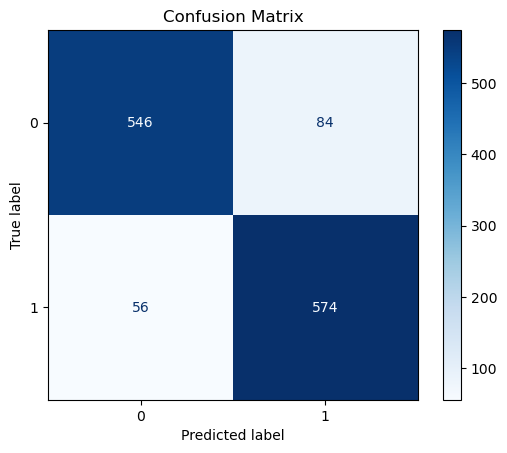

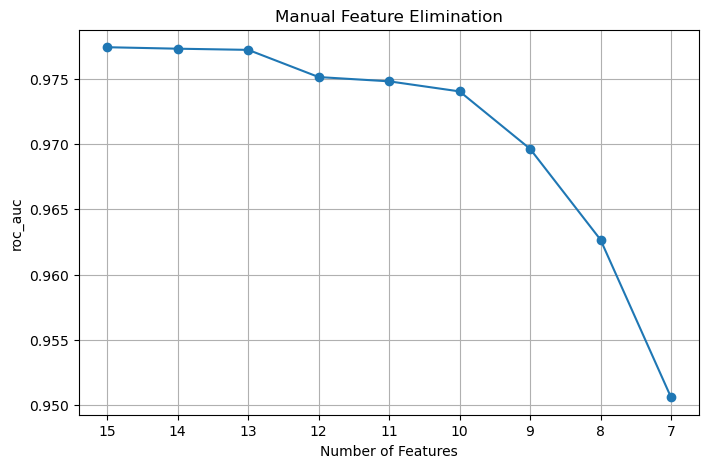


Best feature set (before performance drop): ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
Number of features: 8


In [27]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    criterion='entropy', max_depth=None, max_features='sqrt',
    min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42
)

best_features, feature_sets, scores_list = recursive_feature_elimination(
    rf, X_train, X_test, y_train, y_test, scoring='roc_auc', early_stop_drop=0.02
)



=== Feature Elimination ===

15 features → roc_auc: 0.8954
Accuracy: 0.8516
Confusion Matrix:
[[528 102]
 [ 85 545]]
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
--------------------------------------------------------------------------------
14 features → roc_auc: 0.9000
Accuracy: 0.8508
Confusion Matrix:
[[524 106]
 [ 82 548]]
Current feature set: ['male', 'age', 'education', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
--------------------------------------------------------------------------------
13 features → roc_auc: 0.8931
Accuracy: 0.8476
Confusion Matrix:
[[524 106]
 [ 86 544]]
Current feature set: ['male', 'age', 'education', 'cigsPerDay', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'gluc

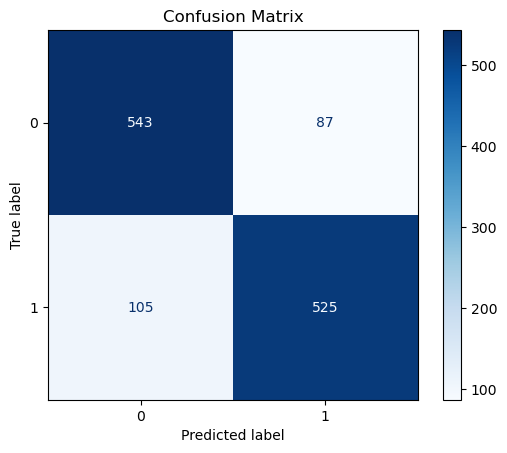

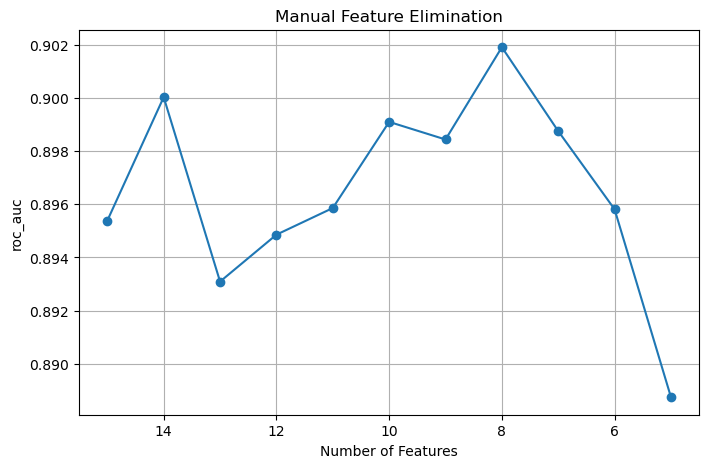


Best feature set (before performance drop): ['age', 'cigsPerDay', 'totChol', 'sysBP', 'BMI', 'heartRate']
Number of features: 6


In [28]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree
dt = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=None, 
    min_samples_leaf=5, 
    min_samples_split=2
)


best_features, feature_sets, scores_list = recursive_feature_elimination(
    dt, X_train, X_test, y_train, y_test, scoring='roc_auc', early_stop_drop=0.01
)



=== Feature Elimination ===

15 features → roc_auc: 0.9779
Accuracy: 0.9294
Confusion Matrix:
[[583  47]
 [ 42 588]]
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
--------------------------------------------------------------------------------
14 features → roc_auc: 0.9784
Accuracy: 0.9310
Confusion Matrix:
[[587  43]
 [ 44 586]]
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
--------------------------------------------------------------------------------
13 features → roc_auc: 0.9783
Accuracy: 0.9294
Confusion Matrix:
[[583  47]
 [ 42 588]]
Current feature set: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']


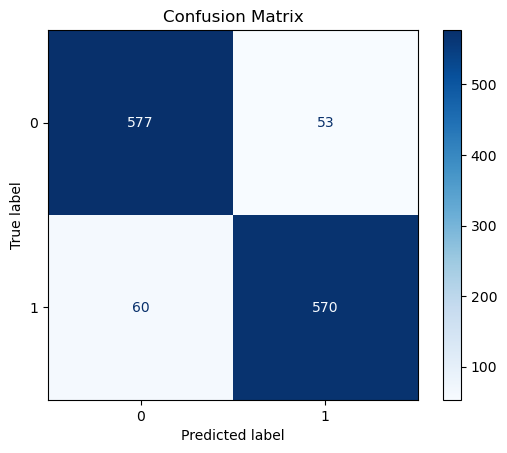

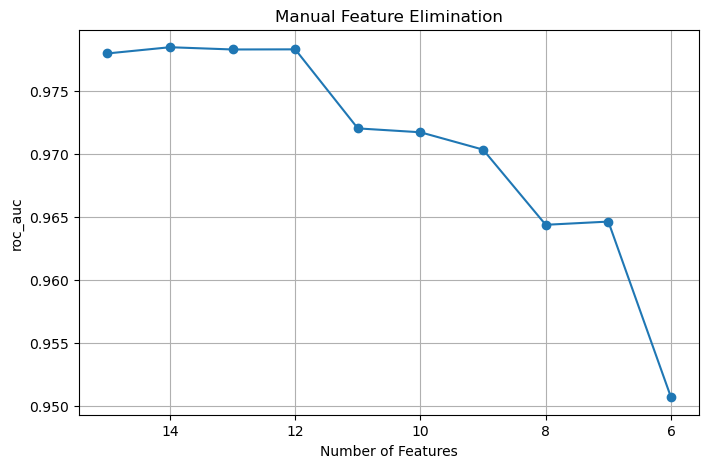


Best feature set (before performance drop): ['male', 'age', 'currentSmoker', 'cigsPerDay', 'sysBP', 'heartRate', 'glucose']
Number of features: 7


In [11]:
import xgboost as xgb

# XGBoost
xgboost_model = xgb.XGBClassifier(
    colsample_bytree=0.8, 
    learning_rate=0.05,
    gamma=0,
    max_depth=20, 
    n_estimators=500, 
    subsample=0.8
)

best_features, feature_sets, scores_list = recursive_feature_elimination(
    xgboost_model, X_train, X_test, y_train, y_test, scoring='roc_auc', early_stop_drop=0.02
)

### **Model Comparison Summary**

| Metric                | Decision Tree | Random Forest | XGBoost |
| :-------------------- | :------------ | :------------ | :------ |
| **Accuracy**          | 0.8540        | 0.9294        | 0.8984  |
| **Precision**         | 0.8431        | 0.9130        | 0.9061  |
| **Recall**            | 0.8698        | 0.9492        | 0.8889  |
| **F1 Score**          | 0.8563        | 0.9307        | 0.8974  |
| **AUC**               | 0.8993        | 0.9774        | 0.8984  |
| **Training Time (s)** | 5.84          | 470.14        | 8.95    |

| Metric                | Decision Tree (Reduced) | Random Forest (Reduced) | XGBoost (Reduced) |
| :-------------------- | :---------------------- | :---------------------- | :---------------- |
| **Accuracy**          | 0.8516                  | 0.8889                  | 0.8937            |
| **Precision**         | 0.8613                  | 0.8723                  | 0.9175            |
| **Recall**            | 0.8381                  | 0.9111                  | 0.8651            |
| **F1 Score**          | 0.8496                  | 0.8913                  | 0.8905            |
| **AUC**               | 0.8986                  | 0.9626                  | 0.9558            |
| **Training Time (s)** | 1.78                    | 46.7                    | 8.96              |

---

### **Performance and Time Trade-offs**

#### **Decision Tree**

* **Accuracy:** 0.854 → 0.852 (↓ 0.3%)
* **Precision:** 0.843 → 0.861 (↑ 2.1%)
* **Recall:** 0.870 → 0.838 (↓ 3.6%)
* **F1 Score:** 0.856 → 0.850 (↓ 0.7%)
* **AUC:** 0.899 → 0.899 (≈ same)
* **Time:** 5.84s → 1.78s (↓ 69.5% faster)

 **Summary:** The reduced Decision Tree runs **~70% faster** with nearly identical accuracy and AUC. Minor recall drop is offset by slightly better precision — a very efficient trade-off.

---

#### **Random Forest**

* **Accuracy:** 0.929 → 0.889 (**↓ 4.3%**)
* **Precision:** 0.913 → 0.872 (**↓ 4.5%**)
* **Recall:** 0.949 → 0.911 (**↓ 4.0%**)
* **F1 Score:** 0.931 → 0.891 (**↓ 4.3%**)
* **AUC:** 0.977 → 0.963 (**↓ 1.5%**)
* **Time:** 470.1 s → 46.7 s (**↓ 90.1% faster**)

**Summary:**
After recursive feature elimination, the Random Forest model runs **about 90% faster** while experiencing a **~4% drop** in accuracy, precision, recall, and F1.
AUC remains high (0.96 vs 0.98), so overall classification quality is still excellent — this is a solid trade-off when computational efficiency is a priority.

---

#### **XGBoost**

* **Accuracy:** 0.898 → 0.894 (↓ 0.4%)
* **Precision:** 0.906 → 0.918 (↑ 1.3%)
* **Recall:** 0.889 → 0.865 (↓ 2.7%)
* **F1 Score:** 0.897 → 0.891 (↓ 0.6%)
* **AUC:** 0.898 → 0.956 (↑ 6.4%)
* **Time:** 8.95s → 8.96s (≈ same)

 **Summary:** The reduced XGBoost model maintains nearly identical training time and accuracy, while **improving AUC notably (+6%)**. It slightly trades recall for precision, indicating stronger confidence in its positive predictions.
